# Calculating X/A ratio (X-loss)

**Run with conda env: R_scRNAseq**

### load packages

In [1]:
suppressPackageStartupMessages({
    library(Seurat)
    library(dplyr)
    library(readr)
    library(ggplot2)
    library(tidyr)
    library(tibble)
    library(viridis)
})

Warning message:
"package 'Seurat' was built under R version 3.6.2"

In [2]:
setwd("/staging/leuven/stg_00041/Adrian/TALON_JANISZEWSKI_XCR2")

### I/O

In [3]:
io <- list()
io$seurat <- "BART_XO/reprogramming.seurat.rds"
io$gene_chr <- "/staging/leuven/stg_00041/genomes/mm10_GRCm38.p6/genemetadata.csv"
io$clusters <- "BART_XO/reprogramming_adrian_bart_4"

io$allele <- "BART_XO/allelic_final.rds"

### Prepare datasets

In [4]:
# Import seurat file
seurat <- readRDS(io$seurat)

# Import integrated seurat file for clusters
clusters <- readRDS(io$clusters)

# Import allelic resolution
allelic <- readRDS(io$allele)

# Import gene - chr annotation
chr_gene_map <- read_csv(io$gene_chr)
chr_gene_map <- data.frame(chr_gene_map, row.names = chr_gene_map$X1)
chr_gene_map <- data.frame(chr_gene_map)
colnames(chr_gene_map) <- c("gene", "Chr")

Warning message:
"Missing column names filled in: 'X1' [1]"Parsed with column specification:
cols(
  X1 = col_character(),
  Chr = col_character()
)


In [5]:
head(allelic)

gene,RNA_id,X.x,X129,Cast,sumReads,ratioPercent,ratioLog,X.y,orig.ident,...,integrated_snn_res.0.4,rownames,cluster_replace,cell_anno,Chr,total_reads,mus_norm,cast_norm,ratio_norm,sum_norm
0610009B22Rik,plate1_B05,246272,0,0,0,NA,NA,plate1_B05,plate1,...,5,plate1_B05,4,Unclassified,chr11,206011,0.0000000,0.0000000,NaN,0.0000000
0610009B22Rik,plate1_B04,230880,0,5,5,0.0001000,-1.328771e+01,plate1_B04,plate1,...,4,plate1_B04,3,Late Pluripotency,chr11,185056,0.0000000,0.2391653,0.0000000,0.2391653
0610009B22Rik,plate2_F02,2416544,2,5,7,0.2858143,-1.321567e+00,plate2_F02,plate2,...,3,plate2_F02,5,iPSC,chr11,131809,0.1412692,0.3216028,0.3052015,0.4628720
0610009B22Rik,plate2_C12,2016352,3,10,13,0.2308692,-1.736485e+00,plate2_C12,plate2,...,2,plate2_C12,0,MEF,chr11,172652,0.1602122,0.4569182,0.2596083,0.6171305
0610009B22Rik,plate2_D05,2093312,10,8,18,0.5556556,3.220435e-01,plate2_D05,plate2,...,3,plate2_D05,5,iPSC,chr11,153580,0.5014578,0.4193030,0.5446124,0.9207608
0610009B22Rik,plate2_A04,1523808,3,3,6,0.5001000,1.442623e-04,plate2_A04,plate2,...,3,plate2_A04,5,iPSC,chr11,216451,0.1297990,0.1297990,0.5000000,0.2595980


In [6]:
# Extract Normalized RNA count
counts <- as.data.frame(seurat@assays$RNA@data)

# Extract Cell annotations
meta1 <- allelic %>% select(RNA_id, cell_anno) %>% distinct()
rownames(meta1) <- meta1$RNA_id
meta1$RNA_id <- NULL

# Extract tSNE coodinates
meta2 <- clusters@reductions$tsne@cell.embeddings

# Merge
meta <- merge(meta1, meta2, by = "row.names")
colnames(meta) <- c("cell", "cluster", "tSNE_1", "tSNE_2")

In [7]:
head(meta)

cell,cluster,tSNE_1,tSNE_2
plate1_A03,Late Pluripotency,1.9470055,-6.952948
plate1_A04,Late Pluripotency,2.2699379,-5.616999
plate1_A05,Late SSEA1,17.0504146,2.845719
plate1_A06,Late Pluripotency,0.1477059,-9.569271
plate1_A07,Early SSEA1,2.2001259,13.206912
plate1_A08,Late Pluripotency,4.2253420,-5.785899


In [8]:
# Convert RNA file to long format
counts_long <- counts %>% t() %>% 
               as.data.frame() %>% rownames_to_column('cell') %>%
               gather(gene, expr, -cell)

# Annotate long RNA file with Chr for genes
counts_chr <- merge(counts_long, chr_gene_map, by="gene")

### Filtering & Calculations

In [9]:
# Filter out non-expressed genes per cell
counts_filt <- counts_chr %>% filter(expr > 0)

# Define not autosomes
not_A <- c("chrX", "chrY", "chrM")

# Calculate Median expression of autosomes
A <- counts_filt %>% filter(!Chr %in% not_A) %>%
        group_by(cell) %>% summarize(A = median(expr))

# Calculate Median expression of X
X <- counts_filt %>% filter(Chr=="chrX") %>%
        group_by(cell) %>% summarize(X = median(expr))

# Merge A & X Median expression dataframes
cell_XA <- merge(X,A, by="cell")

# Calculate X/A ratio per cell
cell_XA$XA <- cell_XA$X/cell_XA$A


In [10]:
# Annotate X/A ratio dataframe with tSNE coordinates & pseudotime
final <- merge(cell_XA, meta, by="cell")

In [11]:
head(final)

cell,X,A,XA,cluster,tSNE_1,tSNE_2
plate1_A03,0.2501487,0.2416002,1.0353831,Late Pluripotency,1.9470055,-6.952948
plate1_A04,0.2370453,0.2797833,0.8472462,Late Pluripotency,2.2699379,-5.616999
plate1_A05,0.2377602,0.2752159,0.8639044,Late SSEA1,17.0504146,2.845719
plate1_A06,0.2076235,0.2430439,0.8542632,Late Pluripotency,0.1477059,-9.569271
plate1_A07,0.1839409,0.3139116,0.5859640,Early SSEA1,2.2001259,13.206912
plate1_A08,0.2342793,0.2708969,0.8648283,Late Pluripotency,4.2253420,-5.785899


### Plotting & comparing

In [12]:
# Plot new X/A calculations
tsne_new <- ggplot(final, aes(tSNE_1, tSNE_2, color=XA)) + 
            geom_point(color="black", size=2.5, alpha=0.5) +
            geom_point(size=2.2) +         
            scale_color_viridis(option="A", limits=(c(0.44,1.3))) +
            labs(colour = "X/A ratio") + 
            theme_classic()
    
cluster <- ggplot(final, aes(cluster, XA, fill=cluster)) + 
            geom_violin(scale = 'width') +
            geom_boxplot(width=0.3, fill="white") +
            geom_hline(yintercept = c(0.5,1), linetype = 'dashed', size = .5) +
            theme_classic() + theme(legend.position = "none")
            


Warning message:
"Graphs cannot be vertically aligned unless the axis parameter is set. Placing graphs unaligned."

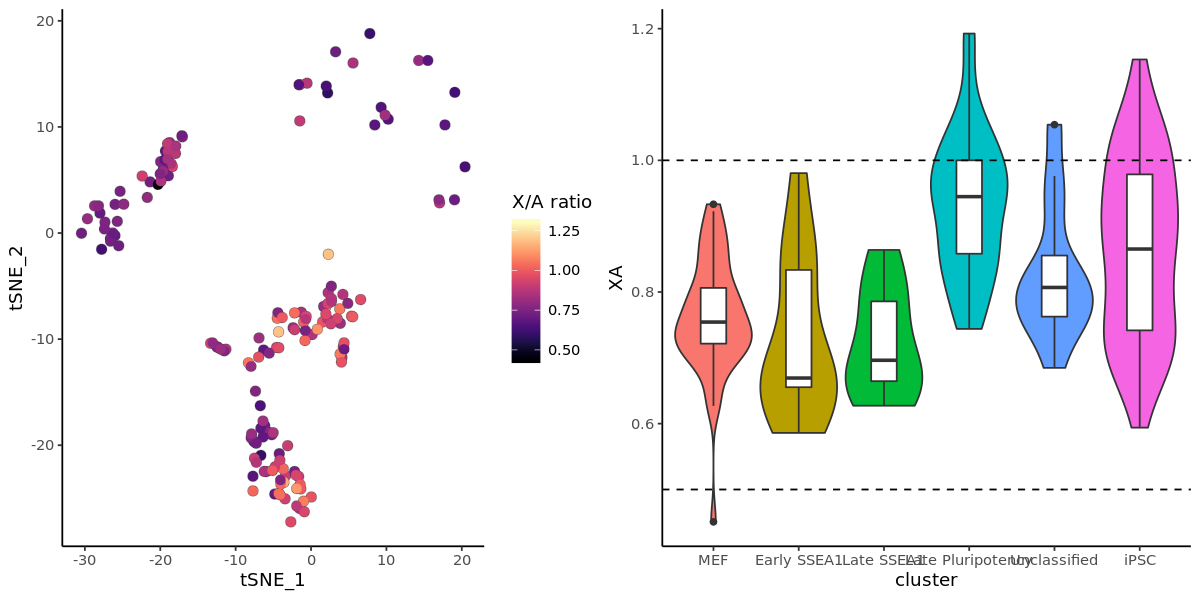

In [13]:
options(repr.plot.width=10, repr.plot.height=5)
plots <- list(tsne_new, cluster)
CombinePlots(plots, ncol=2)

### Investigate X/A of X-loss cells

In [14]:
# Load status of X for iPSC
x_loss <- readRDS("BART_XO/X_loss.rds")
colnames(x_loss) <- c("cell", "group")

In [15]:
# Keep annotated iPSC
keep <- x_loss$cell
loss <- final %>% filter(cell %in% keep)

# Annotate with X state
loss <- merge(loss, x_loss, by="cell")

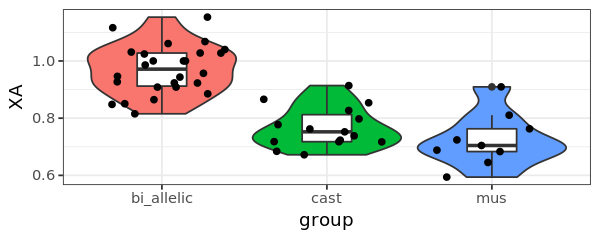

In [16]:
# Plot
cluster <- ggplot(loss, aes(group, XA, fill=group)) + 
            geom_violin(scale = 'width') +
            geom_boxplot(width=0.3, fill="white") +
            geom_jitter(color="black") +
            theme_bw() + theme(legend.position = "none")
options(repr.plot.width=5, repr.plot.height=2)
cluster

### Allelic resolution X/A

In [17]:
# define not autosomes
notA <- c("chrX", "chrY", "chrM")

# keep expressed genes
allelic2 <- allelic %>% filter(sum_norm > 0)

# Calculate expression medians
A <- allelic2 %>% filter(!Chr %in% notA) %>% select(RNA_id, mus_norm, cast_norm, sum_norm, cluster_replace, cell_anno)
A <- A %>% group_by(RNA_id, cell_anno, cluster_replace) %>% summarize(meanA = median(sum_norm), castA = median(cast_norm), musA = median(mus_norm))
X <- allelic2 %>% filter(Chr == "chrX") %>% select(RNA_id, mus_norm, cast_norm, sum_norm)
X <- X %>% group_by(RNA_id) %>% summarize(castX = median(cast_norm), musX = median(mus_norm), meanX = median(sum_norm))

# Divide median X by median A
XA <- merge(A, X, by="RNA_id")
XA$castXA <- XA$castX/XA$meanA
XA$musXA <- XA$musX/XA$meanA

# filter iPSC cluster
XA <- XA %>% filter(cluster_replace==5)
XA <- merge(XA, x_loss, by.x="RNA_id", by.y="cell")

# Make long format for plotting
plot <- XA %>% select(group, castXA, musXA) %>% gather(allele, mean, -group)
plot$mean <- as.numeric(plot$mean)
plotA <- plot %>% filter(allele=="castXA" | allele=="musXA")

# Plot
options(repr.plot.width=5, repr.plot.height=2)
plotA2 <- ggplot(plotA, aes(group, mean, group=allele)) + 
         #   geom_violin(data=plotA, scale = 'width', aes(group=allele)) +
            geom_boxplot(width=0.3, fill="white") +
            theme_bw() + theme(legend.position = "none")


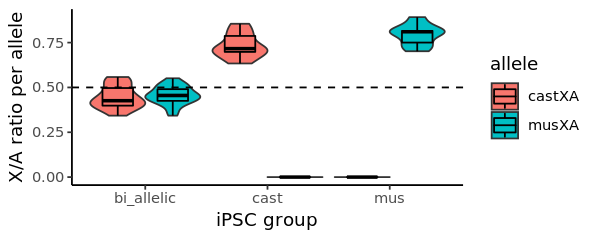

In [18]:
plotA2 <- ggplot(plotA, aes(group, mean, fill=allele)) + 
            geom_violin( scale = 'width') + 
            geom_boxplot(data=plotA,aes(group, mean,color= allele),width=0.5,position = position_dodge(width = 0.9), color="black") +
            theme_classic() + 
            geom_hline(yintercept = 0.5, linetype = 'dashed', size = .5) +
            ylab("X/A ratio per allele") + xlab("iPSC group")
            
plotA2

In [213]:
# Write to PDF
pdf(paste0("BART_XO/X_loss_XA_ratio.pdf"), useDingbats = FALSE, height=2, width=4)
plotA2
dev.off()

png 
  2

# Plotting expression of X and autosomes 

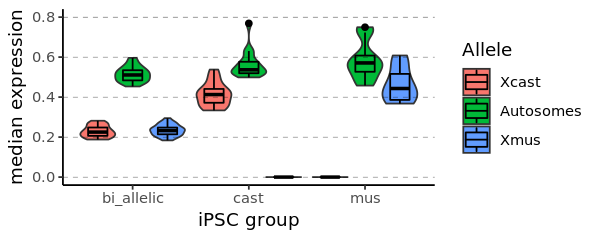

In [19]:
plot <- XA %>% select(group, meanA, castX, musX) %>% gather(allele, mean, -group)
plot$mean <- as.numeric(plot$mean)
keep <- c("meanA", "castX", "musX")
plotA <- plot %>% filter(allele %in% keep)

plotA2 <- ggplot(plotA, aes(group, mean, fill=allele)) + 
            geom_violin( scale = 'width') + 
            geom_boxplot(data=plotA,aes(group, mean,color= allele),width=0.5,position = position_dodge(width = 0.9), color="black") +
            theme_classic() +
            geom_hline(yintercept = c(0,0.8,0.2,0.4,0.6), linetype = 'dashed', size = .1) +
            scale_fill_discrete(name = "Allele", labels = c("Xcast", "Autosomes", "Xmus")) +
            ylab("median expression") + xlab("iPSC group")
            
plotA2

In [51]:
setwd("/ddn1/vol1/staging/leuven/stg_00041/Bart/Exp2/Data/RNA/Figures/")
# Write to PDF
pdf(paste0("X_loss_allelic_expression.pdf"), useDingbats = FALSE, height=2, width=4)
plotA2
dev.off()

png 
  2

## ADRIAN for XCR2 paper 22 January 2021. 
###   
### Which genes upregulate expression in XO cells

In [20]:
head(loss)

cell,X,A,XA,cluster,tSNE_1,tSNE_2,group
plate1_C07,0.2310443,0.2672205,0.8646204,iPSC,4.284099,-10.70842,bi_allelic
plate1_D02,0.2235519,0.2628354,0.8505395,iPSC,4.099511,-11.71793,bi_allelic
plate1_E08,0.2577496,0.2429823,1.0607752,iPSC,3.854021,-11.41039,bi_allelic
plate2_A02,0.2239998,0.2808838,0.7974820,iPSC,-5.942242,-22.48389,cast
plate2_A03,0.2598097,0.3623112,0.7170898,iPSC,-6.145626,-18.16081,cast
plate2_A04,0.2125616,0.3106948,0.6841492,iPSC,-7.569830,-19.65272,cast


In [21]:
head(allelic2)

gene,RNA_id,X.x,X129,Cast,sumReads,ratioPercent,ratioLog,X.y,orig.ident,...,integrated_snn_res.0.4,rownames,cluster_replace,cell_anno,Chr,total_reads,mus_norm,cast_norm,ratio_norm,sum_norm
0610009B22Rik,plate1_B04,230880,0,5,5,0.0001000,-1.328771e+01,plate1_B04,plate1,...,4,plate1_B04,3,Late Pluripotency,chr11,185056,0.0000000,0.2391653,0.0000000,0.2391653
0610009B22Rik,plate2_F02,2416544,2,5,7,0.2858143,-1.321567e+00,plate2_F02,plate2,...,3,plate2_F02,5,iPSC,chr11,131809,0.1412692,0.3216028,0.3052015,0.4628720
0610009B22Rik,plate2_C12,2016352,3,10,13,0.2308692,-1.736485e+00,plate2_C12,plate2,...,2,plate2_C12,0,MEF,chr11,172652,0.1602122,0.4569182,0.2596083,0.6171305
0610009B22Rik,plate2_D05,2093312,10,8,18,0.5556556,3.220435e-01,plate2_D05,plate2,...,3,plate2_D05,5,iPSC,chr11,153580,0.5014578,0.4193030,0.5446124,0.9207608
0610009B22Rik,plate2_A04,1523808,3,3,6,0.5001000,1.442623e-04,plate2_A04,plate2,...,3,plate2_A04,5,iPSC,chr11,216451,0.1297990,0.1297990,0.5000000,0.2595980
0610009B22Rik,plate1_H07,1385280,0,5,5,0.0001000,-1.328771e+01,plate1_H07,plate1,...,0,plate1_H07,1,Early SSEA1,chr11,134067,0.0000000,0.3169601,0.0000000,0.3169601


In [23]:
X_loss_allelic <- merge(allelic2, loss, by.x="RNA_id", by.y="cell")

In [24]:
X_loss_allelic_clean <- X_loss_allelic %>% 
                        filter(Chr == "chrX") %>% 
                        select(RNA_id, gene, mus_norm, cast_norm, group) %>%
                        group_by(group, gene) %>%
                        summarize(mean_mus_norm = mean(mus_norm), mean_cast_norm = mean(cast_norm)) %>%
                        ungroup()

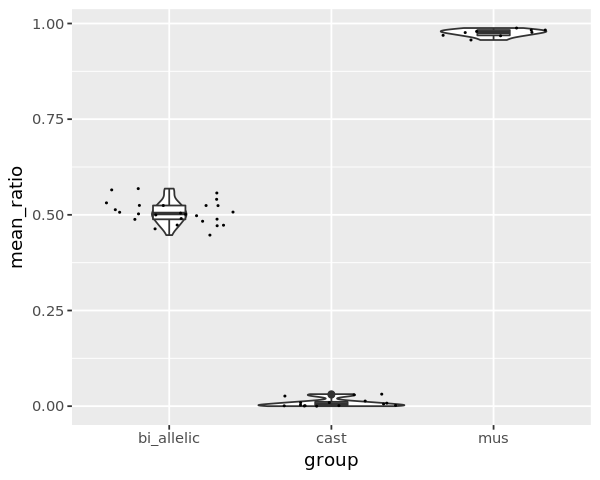

In [34]:
options(repr.plot.height = 4)

X_loss_allelic %>% 
            filter(Chr == "chrX") %>%
            group_by(group, RNA_id) %>% 
            summarize(mean_ratio = mean(ratio_norm)) %>% 
            ggplot(aes(group, mean_ratio)) +
                geom_violin() +
                geom_boxplot(width =.2) +
                geom_jitter(size = .2)

In [35]:
X_loss_allelic_clean %>% head()

group,gene,mean_mus_norm,mean_cast_norm
bi_allelic,1110012L19Rik,0.40312475,0.42560974
bi_allelic,1700013H16Rik,0.71960823,0.86962356
bi_allelic,1700080O16Rik,0.07048820,0.64394324
bi_allelic,1810030O07Rik,0.30744713,0.03753753
bi_allelic,2010204K13Rik,0.09365663,0.05286289
bi_allelic,2810403D21Rik,0.01760944,0.13496197


In [26]:
X_loss_genes_bi <- X_loss_allelic_clean %>% 
                        filter(group == "bi_allelic") %>%
                        select(-group) %>%
                        rename("biallelic_mean_mus_norm"=mean_mus_norm,
                              "biallelic_mean_cast_norm"=mean_cast_norm)

X_loss_genes_XCast_OMus <- X_loss_allelic_clean %>% 
                        filter(group == "cast") %>%
                        select(-group) %>%
                        rename("XCast_OMus_mean_mus_norm"=mean_mus_norm,
                              "XCast_OMus_mean_cast_norm"=mean_cast_norm)

X_loss_genes_XMus_OCast <- X_loss_allelic_clean %>% 
                        filter(group == "mus") %>%
                        select(-group) %>%
                        rename("XMus_OCast_mean_mus_norm"=mean_mus_norm,
                              "XMus_OCast_mean_cast_norm"=mean_cast_norm)

In [27]:
bi_cast <- X_loss_genes_bi %>%
                    inner_join(X_loss_genes_XCast_OMus, by = "gene") %>% 
                    select(gene, 
                           biallelic_mean_mus_norm,
                           biallelic_mean_cast_norm, 
                           XCast_OMus_mean_cast_norm) 
                    

bi_mus <- X_loss_genes_bi %>% 
                    inner_join(X_loss_genes_XMus_OCast, by = "gene") %>% 
                    select(gene, 
                           biallelic_mean_mus_norm,
                           biallelic_mean_cast_norm,
                           XMus_OCast_mean_mus_norm)           


	Wilcoxon rank sum test with continuity correction

data:  expression by group_allele
W = 55047, p-value = 2.104e-13
alternative hypothesis: true location shift is not equal to 0


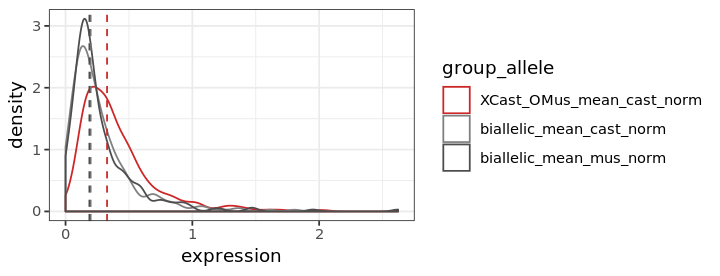


	Wilcoxon rank sum test with continuity correction

data:  expression by group_allele
W = 45419, p-value = 4.097e-14
alternative hypothesis: true location shift is not equal to 0


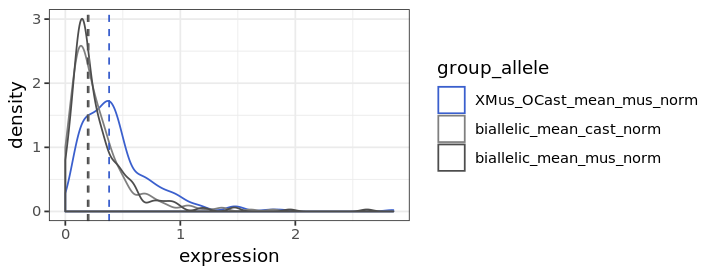

In [28]:
options(repr.plot.width=6, repr.plot.height=2.3)
bi_cast_plot <- bi_cast %>% gather(group_allele, expression, -gene) %>%
                ggplot(aes(expression, color = group_allele)) +
                    geom_density() +
                    scale_color_manual(values = c("firebrick3","grey50","grey30"))+
                    geom_vline(xintercept = median(bi_cast$XCast_OMus_mean_cast_norm),
                               linetype = "dashed",
                                color = "firebrick3")+
                    geom_vline(xintercept = median(bi_cast$biallelic_mean_cast_norm),
                               linetype = "dashed",
                                color = "grey50")+
                    geom_vline(xintercept = median(bi_cast$biallelic_mean_mus_norm),
                               linetype = "dashed",
                                color = "grey30")+
                    theme_bw()
bi_cast_plot

test_bi_cast <- bi_cast %>% 
                mutate(mean_mus_cast_in_biallelic = (biallelic_mean_mus_norm+biallelic_mean_cast_norm)/2) %>%
                select(-c(biallelic_mean_mus_norm, biallelic_mean_cast_norm)) %>% 
                gather(group_allele, expression, -gene)

test_bi_cast_res <- wilcox.test(expression ~ group_allele, data = test_bi_cast,
                   exact = FALSE)
test_bi_cast_res

bi_mus_plot <- bi_mus %>% gather(group_allele, expression, -gene) %>%
                ggplot(aes(expression, color = group_allele)) +
                    geom_density() +
                    scale_color_manual(values = c("royalblue3","grey50","grey30"))+
                    geom_vline(xintercept = median(bi_mus$XMus_OCast_mean_mus_norm),
                               linetype = "dashed",
                                color = "royalblue3")+
                    geom_vline(xintercept = median(bi_mus$biallelic_mean_cast_norm),
                               linetype = "dashed",
                                color = "grey50")+
                    geom_vline(xintercept = median(bi_mus$biallelic_mean_mus_norm),
                               linetype = "dashed",
                                color = "grey30")+
                    theme_bw()
bi_mus_plot

test_bi_mus <- bi_mus %>% 
                mutate(mean_mus_cast_in_biallelic = (biallelic_mean_mus_norm+biallelic_mean_cast_norm)/2) %>%
                select(-c(biallelic_mean_mus_norm, biallelic_mean_cast_norm)) %>% 
                gather(group_allele, expression, -gene)

test_bi_mus_res <- wilcox.test(expression ~ group_allele, data = test_bi_mus,
                   exact = FALSE)
test_bi_mus_res

In [29]:
pdf("BART_XO/XCastXOMus_vs_biallelic_expression.pdf", width = 6, height = 2.3)
plot(bi_cast_plot)
dev.off()

pdf("BART_XO/XMusXOCast_vs_biallelic_expression.pdf", width = 6, height = 2.3)
plot(bi_mus_plot)
dev.off()

png 
  2

png 
  2

[1] "Median level of upregulation in FC =  1.48692044825941"
[1] "Total number of genes measured =  285"
[1] "Number of genes that upregulated by at least 25% (FC = 1.25) =  186"


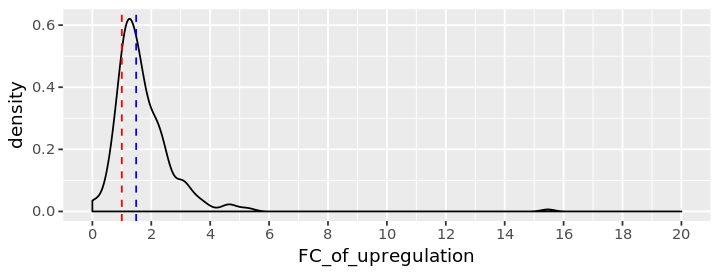

In [30]:
# Which genes are upregulated on Cast when Mus is lost?

bi_cast <- bi_cast %>% mutate(mean_mus_cast_in_biallelic = (biallelic_mean_mus_norm+biallelic_mean_cast_norm)/2,
                   FC_of_upregulation = (XCast_OMus_mean_cast_norm/mean_mus_cast_in_biallelic)) 

bi_cast %>% ggplot(aes(FC_of_upregulation)) + 
            geom_density() +
            geom_vline(xintercept = 1, linetype="dashed", color = "red")+
            geom_vline(xintercept = median(bi_cast$FC_of_upregulation), linetype="dashed", color = "blue")+
            scale_x_continuous(limits = c(0, 20), breaks = seq(0, 20, by = 2))

# What is the median level of upregulation?
print(paste("Median level of upregulation in FC = ",median(bi_cast$FC_of_upregulation)))

# Which genes upregulated by at least 25% more?
print(paste("Total number of genes measured = ",bi_cast %>% nrow()))
print(paste("Number of genes that upregulated by at least 25% (FC = 1.25) = ",bi_cast %>% filter(FC_of_upregulation > 1.25) %>% nrow()))

[1] "Median level of upregulation in FC =  1.56373227516532"
[1] "Total number of genes measured =  256"
[1] "Number of genes that upregulated by at least 25% (FC = 1.25) =  166"


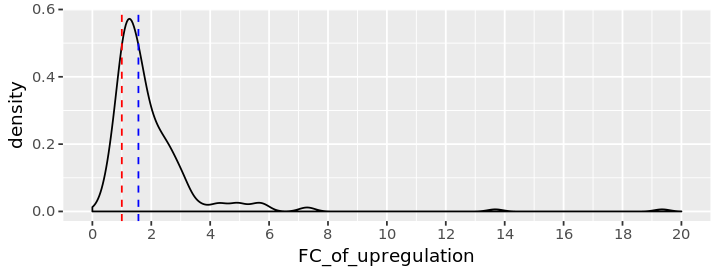

In [31]:
# Which genes are upregulated on Mus when Cast is lost?

bi_mus <- bi_mus %>% mutate(mean_mus_cast_in_biallelic = (biallelic_mean_mus_norm+biallelic_mean_cast_norm)/2,
                   FC_of_upregulation = (XMus_OCast_mean_mus_norm/mean_mus_cast_in_biallelic)) 

bi_mus %>% ggplot(aes(FC_of_upregulation)) + 
            geom_density() +
            geom_vline(xintercept = 1, linetype="dashed", color = "red")+
            geom_vline(xintercept = median(bi_mus$FC_of_upregulation), linetype="dashed", color = "blue")+
            scale_x_continuous(limits = c(0, 20), breaks = seq(0, 20, by = 2))

# What is the median level of upregulation?
print(paste("Median level of upregulation in FC = ",median(bi_mus$FC_of_upregulation)))

# Which genes upregulated by at least 25% more?
print(paste("Total number of genes measured = ",bi_mus %>% nrow()))
print(paste("Number of genes that upregulated by at least 25% (FC = 1.25) = ",bi_mus %>% filter(FC_of_upregulation > 1.25) %>% nrow()))

In [183]:
# What are the common genes on both alleles that upregulate

upregulating_genes <- bi_mus %>%
                    inner_join(bi_cast, by = "gene") %>% 
                    filter(FC_of_upregulation.x > 1.25 & FC_of_upregulation.y > 1.25)

print(paste("Number of genes that upregulate on both alleles upon loss of the other allele, by at least 25% = ",
            upregulating_genes %>% nrow()))

[1] "Number of genes that upregulate on both alleles upon loss of the other allele, by at least 25% =  108"


In [33]:
write.csv(upregulating_genes, "BART_XOupregulating_genes_AJ_BT_XCU_XO.csv")

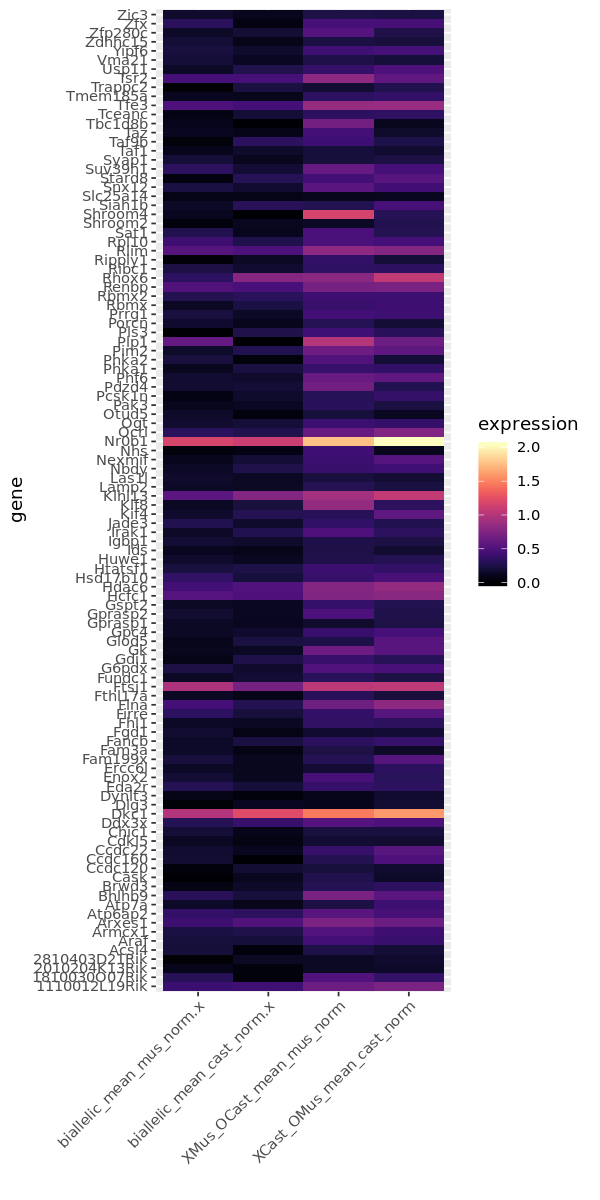

In [34]:
options(repr.plot.width=5, repr.plot.height=10)
upregulating_genes %>% select(gene,
                              biallelic_mean_mus_norm.x, 
                              biallelic_mean_cast_norm.x,
                              XMus_OCast_mean_mus_norm,
                              XCast_OMus_mean_cast_norm) %>%
                        gather(group_allele, expression, -gene) %>%
                       # filter(expression > 0) %>%

                    ggplot(aes(x=factor(group_allele, 
                                      levels = c("biallelic_mean_mus_norm.x", 
                              "biallelic_mean_cast_norm.x",
                              "XMus_OCast_mean_mus_norm",
                              "XCast_OMus_mean_cast_norm")),gene, fill = expression))+
                            geom_tile() +
                            xlab("")+
                            theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))+
                            scale_fill_viridis(option="A")